In [136]:
%matplotlib inline


# Translation with a Sequence to Sequence Network and Attention
*************************************************************
Adapted from: <https://github.com/spro/practical-pytorch>

In this tutorial we will be teaching a neural network to translate from French to English. 

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the `sequence
to sequence network <https://arxiv.org/abs/1409.3215>`__, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

To improve upon this model we'll use an `attention
mechanism <https://arxiv.org/abs/1409.0473>`__, which lets the decoder
learn to focus over a specific range of the input sequence.

**Recommended Reading:**

It would also be useful to know about Sequence to Sequence networks and
how they work:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <https://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <https://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <https://arxiv.org/abs/1506.05869>`__



Loading data files
==================

The data for this project is a set of many thousands of English to
French translation pairs.

    I am cold.    J'ai froid.

Download the data and extract it to the current directory.



Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

In [101]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.




In [102]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [103]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [104]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [105]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [106]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['c est une femme d affaire a succes .', 'she s a successful businesswoman .']


The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <https://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

![](https://i.imgur.com/tVtHhNp.png)

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

<img src="images/06/encoder-network.png">

In [107]:
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size)

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    def forward(self, input, hidden):
        embs = self.embedding(input).view(len(input), 1, -1)
        output, hidden = self.gru(embs, hidden)
        return output, hidden

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.

### Simple Decoder

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

In [108]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size)
        self.out = nn.Linear(hidden_size, vocab_size)

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

    def forward(self, input, hidden):
        embs = self.embedding(input).view(len(input), 1, -1)
        output, hidden = self.gru(embs, hidden)
        output = output.view(len(input), -1)
        output = F.log_softmax(self.out(output), dim=1)
        return output, hidden

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [109]:
def tensorFromSentence(sentence):
    input_ids = [input_lang.word2index[word] for word in sentence.split(' ')]
    input_tensor = torch.LongTensor(input_ids + [EOS_token])
    return input_tensor

def tensorsFromPair(pair):
    input_ids = [input_lang.word2index[word] for word in pair[0].split(' ')]
    target_ids = [output_lang.word2index[word] for word in pair[1].split(' ')]
    input_tensor = torch.LongTensor(input_ids + [EOS_token])
    target_tensor = torch.LongTensor([SOS_token] + target_ids + [EOS_token])
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

In [110]:
def train(input_tensor, target_tensor, encoder, decoder, criterion, optimizer, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    ############## TODO #################
    # Implement a seq2seq model 
    # Get encoder hidden states and outputs
    
    # Initialize decoder hidden state
    
    # Get decoder hidden states and outputs
    
    # Define the loss function
    
    #####################################

    loss.backward()

    optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [111]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [155]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    parameters = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = optim.SGD(parameters, lr=learning_rate)
    criterion = nn.NLLLoss()
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, criterion, optimizer)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [156]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# Training

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




In [157]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size, hidden_size).to(device)
decoder = DecoderRNN(output_lang.n_words, hidden_size, hidden_size).to(device)

trainIters(encoder, decoder, 10000, print_every=1000)

TypeError: forward() takes 3 positional arguments but 4 were given

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [66]:
def evaluate(encoder, decoder, input_tensor, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_length = len(input_tensor)
        
        encoder_hidden = encoder.initHidden()

        encoder_init = encoder.initHidden()
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_init)

        decoder_input = torch.tensor([SOS_token], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze(1).detach()

        return decoded_words

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [67]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, tensorsFromPair(pair)[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [72]:
evaluateRandomly(encoder, decoder)

> il n est plus ce qu il etait .
= he is not what he used to be .
< they re not a good . <EOS>

> je ne suis pas en service aujourd hui .
= i am off today .
< i m not a good . <EOS>

> je ne suis pas grincheuse .
= i m not cranky .
< i m not a good . <EOS>

> nous sommes bourres .
= we re plastered .
< we re not a good . <EOS>

> vous etes dure .
= you re tough .
< you re very good . <EOS>

> elle est en danger .
= she s in danger .
< i m not a good . <EOS>

> il n est plus celui qu il etait .
= he is not what he used to be .
< they re not a good . <EOS>

> je suis une personne occupee .
= i m a busy person .
< i m not a good . <EOS>

> elle est occupee a apprendre l anglais .
= she is busy learning english .
< they re not a good . <EOS>

> je te suis reconnaissant pour ta gentillesse .
= i am grateful to you for your kindness .
< i m not a good . <EOS>



## Attention Decoder

If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

![](https://i.imgur.com/5y6SCvU.png)

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

![](https://i.imgur.com/K1qMPxs.png)

### Bahdanau attention

The attention model in [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473) is described as the following series of equations.

Each decoder output is conditioned on the previous outputs and some $\mathbf x$, where $\mathbf x$ consists of the current hidden state (which takes into account previous outputs) and the attention "context", which is calculated below. The function $g$ is a fully-connected layer with a nonlinear activation, which takes as input the values $y_{i-1}$, $s_i$, and $c_i$ concatenated.

$$
p(y_i \mid \{y_1,...,y_{i-1}\},\mathbf{x}) = g(y_{i-1}, s_i, c_i)
$$

The current hidden state $s_i$ is calculated by an RNN $f$ with the last hidden state $s_{i-1}$, last decoder output value $y_{i-1}$, and context vector $c_i$.

In the code, the RNN will be a `nn.GRU` layer, the hidden state $s_i$ will be called `hidden`, the output $y_i$ called `output`, and context $c_i$ called `context`.

$$
s_i = f(s_{i-1}, y_{i-1}, c_i)
$$

The context vector $c_i$ is a weighted sum of all encoder outputs, where each weight $a_{ij}$ is the amount of "attention" paid to the corresponding encoder output $h_j$.

$$
c_i = \sum_{j=1}^{T_x} a_{ij} h_j
$$

... where each weight $a_{ij}$ is a normalized (over all steps) attention "energy" $e_{ij}$ ...

$$
a_{ij} = \dfrac{exp(e_{ij})}{\sum_{k=1}^{T} exp(e_{ik})}
$$

... where each attention energy is calculated with some function $a$ (such as another linear layer) using the last hidden state $s_{i-1}$ and that particular encoder output $h_j$:

$$
e_{ij} = a(s_{i-1}, h_j) = s_{i-1}^T W h_j
$$

### Implementing Bahdanau attention

In summary our decoder should consist of four main parts - an embedding layer turning an input word into a vector; a layer to calculate the attention energy per encoder output; a RNN layer; and an output layer.

The decoder's inputs are the last RNN hidden state $s_{i-1}$, last output $y_{i-1}$, and all encoder outputs $h_*$.

* embedding layer with inputs $y_{i-1}$
    * `embedded = embedding(last_rnn_output)`
    
* attention layer $a$ with inputs $(s_{i-1}, h_j)$ and outputs $e_{ij}$, normalized to create $a_{ij}$
    * `attn_energies[j] = attn_layer(last_hidden, encoder_outputs[j])`
    * `attn_weights = normalize(attn_energies)`
    
* context vector $c_i$ as an attention-weighted average of encoder outputs
    * `context = sum(attn_weights * encoder_outputs)`
    
* RNN layer(s) $f$ with inputs $(s_{i-1}, y_{i-1}, c_i)$ and internal hidden state, outputting $s_i$
    * `rnn_input = concat(embedded, context)`
    * `rnn_output, rnn_hidden = rnn(rnn_input, last_hidden)`
    
* an output layer $g$ with inputs $(y_{i-1}, s_i, c_i)$, outputting $y_i$
    * `output = out(embedded, rnn_output, context)`

In [212]:
class Attn(nn.Module):
    def __init__(self, hidden_size):
        super(Attn, self).__init__()
        self.linear = nn.Linear(hidden_size, hidden_size)

    def forward(self, query, keys):
        # query: 1 x 1 x H
        # keys: 1 x T x H
        
        ########## TODO ############
        # Implement an attention layer
        
        # Compute attention weights
        # attn_weights: 1 x 1 x T
        
        # Compute context vector
        # context: 1 x 1 x H
        
        #############################
        
        return attn_weights, context

In [230]:
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(BahdanauAttnDecoderRNN, self).__init__()
        
        # Define parameters
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        
        # Define layers
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.gru = nn.GRU(self.embedding_size + self.hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size * 2, vocab_size)
        
        # Attention
        self.attn = Attn(hidden_size)
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note that we will only be running forward for a single decoder time step, but will use all encoder outputs
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        ################# TODO ####################
        # Calculate attention weights and apply to encoder outputs
        attn_weights, context = None, None
        
        # Construct RNN input
        rnn_input = None
        
        # Update RNN hidden state
        rnn_output, hidden = None, None
        
        # Compute output (pre-softmax activations)
        output = None
        
        ############################################
        
        output = F.log_softmax(self.out(output), dim=-1)
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

In [231]:
def train(input_tensor, target_tensor, encoder, decoder, criterion, optimizer, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    encoder_init = encoder.initHidden()
    encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_init)

    decoder_hidden = encoder_hidden

    decoder_outputs = torch.zeros(len(target_tensor) - 1, output_lang.n_words)
    for di in range(len(target_tensor) - 1):
        decoder_input = target_tensor[[di]]
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        decoder_outputs[di] = decoder_output
    
    loss = criterion(decoder_outputs, target_tensor[1:])

    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), 5.0)
    optimizer.step()

    return loss.item() / target_length

In [ ]:
hidden_size = 256

encoder = EncoderRNN(input_lang.n_words, hidden_size, hidden_size).to(device)
decoder = BahdanauAttnDecoderRNN(output_lang.n_words, hidden_size, hidden_size).to(device)

trainIters(encoder, decoder, 50000, print_every=1000)

/Users/llajan/miniconda2/envs/dlcourse/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


1m 6s (- 54m 1s) (1000 2%) 0.5080
2m 2s (- 49m 11s) (2000 4%) 0.3962
3m 3s (- 47m 54s) (3000 6%) 0.3795
4m 1s (- 46m 12s) (4000 8%) 0.3626
5m 0s (- 45m 7s) (5000 10%) 0.3530
5m 54s (- 43m 19s) (6000 12%) 0.3418


In [233]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(sentence)
        input_length = len(input_tensor)
        
        encoder_hidden = encoder.initHidden()

        encoder_init = encoder.initHidden()
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_init)

        decoder_input = torch.tensor([SOS_token], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, input_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze(1).detach()

        return decoded_words, decoder_attentions[:di + 1]

In [234]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [235]:
evaluateRandomly(encoder, decoder)

> je plaisante .
= i m kidding .
< i m not a good . <EOS>

> elle ne convient pas a la tache .
= she isn t adequate to the task .
< he is a good . <EOS>

> j ai dix huit ans .
= i m eighteen .
< i m not a good . <EOS>

> me voila satisfaite .
= i m contented .
< he is a good . <EOS>

> c est mon vieux compagnon de beuverie .
= he s my old drinking buddy .
< he is a good . <EOS>

> nous nous rendons au cinema .
= we re going to the movies .
< we re not a good . <EOS>

> il lui est tres attache .
= he is deeply attached to her .
< he is a good . <EOS>

> je ne suis pas votre frere .
= i m not your brother .
< i m not a good . <EOS>

> tu es incroyablement naif .
= you are incredibly naive .
< you re very . <EOS>

> il est un peu rouille .
= he s a little rusty .
< he is a good . <EOS>



Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




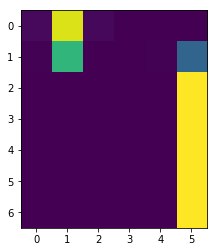

In [236]:
import matplotlib.pyplot as plt
output_words, attentions = evaluate(
    encoder, decoder, "je suis trop froid .")
plt.imshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




input = elle a cinq ans de moins que moi .
output = he is a good . <EOS>
input = elle est trop petit .
output = he is a good . <EOS>
input = je ne crains pas de mourir .
output = i m not a good . <EOS>
input = c est un jeune directeur plein de talent .
output = he is a good . <EOS>


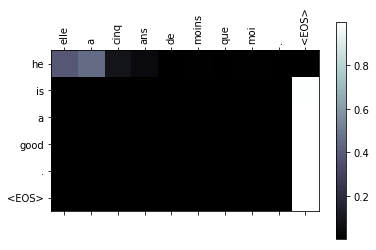

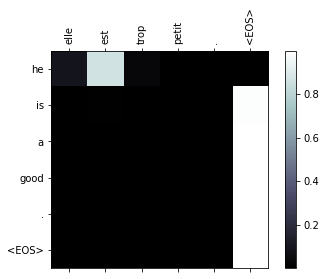

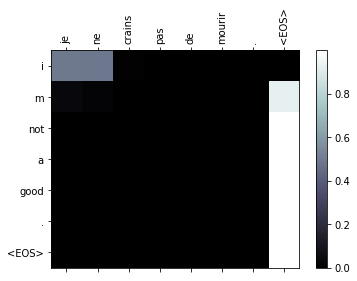

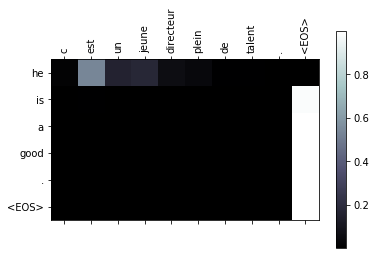

In [237]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

Exercises
=========

-  Try with a different dataset

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

-  Replace the embeddings with pre-trained word embeddings such as word2vec or
   GloVe
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  If you use a translation file where pairs have two of the same phrase
   (``I am test \t I am test``), you can use this as an autoencoder. Try
   this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there


